# Transfer Learning

## Feature Extraction

In [3]:
# Inspect data files (10% of the total data from Food101)

import os

# Walk through data

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent\test
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent\test\fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent\test\grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent\test\hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent\test\pizza
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ramen
There are 0 directories and 250 images in 10_food_classes_10_percent\test\steak
There are 0 directories and 250 images in 10_food_classes_10_percent\test\sushi
There are 10 directori

In [4]:
# Creating data loaders
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode="categorical"
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    class_mode="categorical"
)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [23]:
# Setting up TensorBoard callback
import datetime
from keras.callbacks import TensorBoard

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = f"{dir_name}/{experiment_name}"
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log file to {log_dir}")
    return tensorboard_callback

In [6]:
# Want to compare two models from tensorflow hub

resnet_url = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5"

efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

### Resnet Model

In [18]:
# Making create_model function with arg: url

import tensorflow as tf
import tensorflow_hub as hub
from keras.layers import Input, Dense
from keras import Model

def create_model(model_url, num_class=10):
    """
    Take a TensorFlow Hub URL and creates a keras model with it.

    Args:
        model_url (str): TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in output layers.
    """

    # Download pretrained model and save it as a Keras layer
    feature_extraction_layer = hub.KerasLayer(model_url,
        trainable=False,
        name="Feature_extraction_layer"
    )

    input = Input(shape=(224, 224, 3))
    features = feature_extraction_layer(input)
    output = Dense(num_class, activation="softmax")(features)

    model = Model(inputs=[input], outputs=[output])
    return model

In [19]:
# Create Resnet model

resnet_model = create_model(resnet_url)

resnet_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Feature_extraction_layer (K  (None, 1536)             54336736  
 erasLayer)                                                      
                                                                 
 dense_3 (Dense)             (None, 10)                15370     
                                                                 
Total params: 54,352,106
Trainable params: 15,370
Non-trainable params: 54,336,736
_________________________________________________________________


In [20]:
# Compile Resnet model

from keras.losses import categorical_crossentropy
from keras.optimizers import Adam 

resnet_model.compile(loss=categorical_crossentropy,
    optimizer=Adam(),
    metrics=["accuracy"])

In [24]:
# Train Resnet model

resnet_history = resnet_model.fit(train_data, 
    epochs=5, 
    validation_data=test_data,
    callbacks=[create_tensorboard_callback("tensorflow_hub", experiment_name="resnet_model_food101")])

Saving TensorBoard log file to tensorflow_hub/resnet_model_food101
Epoch 1/5
24/24 [==============================] - 52s 2s/step - loss: 1.5267 - accuracy: 0.4880 - val_loss: 0.9578 - val_accuracy: 0.6708
Epoch 2/5
24/24 [==============================] - 33s 1s/step - loss: 0.8466 - accuracy: 0.7293 - val_loss: 0.7162 - val_accuracy: 0.7704
Epoch 3/5
24/24 [==============================] - 34s 1s/step - loss: 0.6845 - accuracy: 0.7800 - val_loss: 0.6728 - val_accuracy: 0.7824
Epoch 4/5
24/24 [==============================] - 34s 1s/step - loss: 0.6029 - accuracy: 0.8267 - val_loss: 0.7026 - val_accuracy: 0.7680
Epoch 5/5
24/24 [==============================] - 34s 1s/step - loss: 0.5432 - accuracy: 0.8400 - val_loss: 0.6591 - val_accuracy: 0.7804


<Axes: >

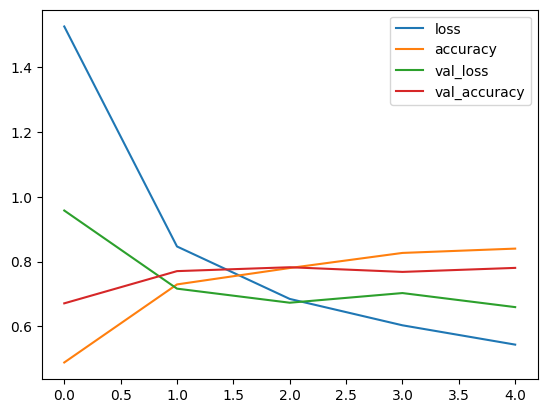

In [25]:
# Plot loss curve
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(resnet_history.history).plot()

### Efficientnet Model

In [26]:
# Create Efficientnet model

efficient_model = create_model(efficientnet_url)

efficient_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Feature_extraction_layer (K  (None, 1280)             5919312   
 erasLayer)                                                      
                                                                 
 dense_4 (Dense)             (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


In [27]:
# Compile Efficientnet model

from keras.losses import categorical_crossentropy
from keras.optimizers import Adam 

efficient_model.compile(loss=categorical_crossentropy,
    optimizer=Adam(),
    metrics=["accuracy"])

In [28]:
# Train Efficientnet model

efficient_history = efficient_model.fit(train_data, 
    epochs=5, 
    validation_data=test_data,
    callbacks=[create_tensorboard_callback("tensorflow_hub", experiment_name="efficientnet_model_food101")])

Saving TensorBoard log file to tensorflow_hub/efficientnet_model_food101
Epoch 1/5
24/24 [==============================] - 25s 652ms/step - loss: 1.9335 - accuracy: 0.3560 - val_loss: 1.5055 - val_accuracy: 0.6004
Epoch 2/5
24/24 [==============================] - 13s 569ms/step - loss: 1.2981 - accuracy: 0.6680 - val_loss: 1.1216 - val_accuracy: 0.7116
Epoch 3/5
24/24 [==============================] - 13s 552ms/step - loss: 1.0071 - accuracy: 0.7560 - val_loss: 0.9530 - val_accuracy: 0.7416
Epoch 4/5
24/24 [==============================] - 13s 550ms/step - loss: 0.8447 - accuracy: 0.7853 - val_loss: 0.8606 - val_accuracy: 0.7568
Epoch 5/5
24/24 [==============================] - 13s 575ms/step - loss: 0.7335 - accuracy: 0.8240 - val_loss: 0.7984 - val_accuracy: 0.7660


<Axes: >

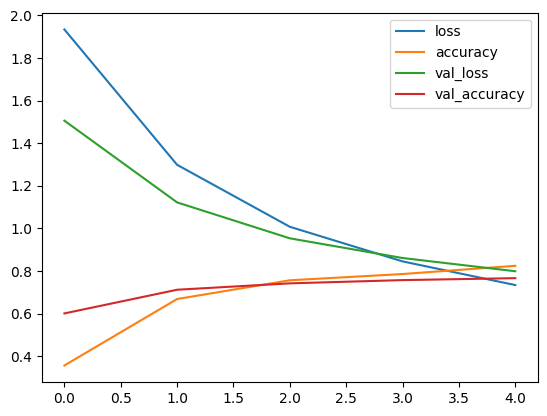

In [29]:
# Plot loss curve
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(efficient_history.history).plot()

### Comparing models using TensorBoard

In [32]:
# Launching in TensorBoard

import tensorboard